### Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


C/A      = Control Area (A002)<br>
UNIT     = Remote Unit for a station (R051)<br>
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)<br>
STATION  = Represents the station name the device is located at<br>
LINENAME = Represents all train lines that can be boarded at this station<br>
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.<br>
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND<br>
DATE     = Represents the date (MM-DD-YY)<br>
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event<br>
DESC     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)<br>
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.
ENTRIES  = The comulative entry register value for a device<br>
EXIST    = The cumulative exit register value for a device<br>

In [2]:
import re
import pandas as pd
import datetime as dt
from collections import defaultdict as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

%matplotlib inline

In [5]:
dates = [303, 310, 317, 324, 331, 407, 414, 421, 428, 505, 512, 519, 526, 602]
date_urls = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_180{}.txt'.format(date) for date in dates]
df_old = pd.concat([pd.read_csv(url) for url in date_urls]).to_csv('origin.csv')

In [190]:
df = pd.read_csv('origin.csv')
df.reset_index(drop=True).head()
df.drop('Unnamed: 0', axis=1, inplace=True)

In [191]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [192]:
df.rename(columns={column:column.strip() for column in df.columns}, inplace=True)

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761040 entries, 0 to 2761039
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: int64(2), object(9)
memory usage: 231.7+ MB


In [194]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,03:00:00,RECOVR AUD,6527780,2210496
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,07:00:00,REGULAR,6527794,2210507
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,11:00:00,REGULAR,6527838,2210585
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,15:00:00,REGULAR,6527994,2210644
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/24/2018,19:00:00,REGULAR,6528278,2210705


In [195]:
# Check how many RECOVER we have
len(df[df.DESC == 'RECOVR AUD']) / len(df)

# Drop the RECOVR AUD
df = df[df.DESC == 'REGULAR']

In [196]:
# Combine DATE & TIME columns and convert them to datetime format
df['DATETIME'] = pd.to_datetime(df.DATE+" "+df.TIME, format='%m/%d/%Y %H:%M:%S')

# Check duplicates - No. Because we dropped RECOVR AUD
df.groupby(['C/A', 'UNIT', 'SCP','STATION', 'DATETIME']).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False).head()

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-02-24 07:00:00,1
1833832,R143,R032,02-03-00,TIMES SQ-42 ST,2018-03-05 07:00:00,1
1833834,R143,R032,02-03-00,TIMES SQ-42 ST,2018-03-05 15:00:00,1
1833835,R143,R032,02-03-00,TIMES SQ-42 ST,2018-03-05 19:00:00,1
1833836,R143,R032,02-03-00,TIMES SQ-42 ST,2018-03-05 23:00:00,1


In [199]:
# Use daily count to find the most popular station
dailycount = df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES', 'EXITS'].first().reset_index()

# Create previous date and previous entries columns for the calculation
dailycount[['PREVDATE', 'PREVENTRIES', 'PREVEXITS']] = dailycount.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'STATION'])['DATE', 'ENTRIES', 'EXITS'].transform(lambda x: x.shift(1))

# Drop the NaN from shifting
dailycount.dropna(subset=['PREVDATE'], inplace=True)

In [213]:
# Calculate the diff
dailycount['ENTRIES_DIFF'] = dailycount['ENTRIES'] - dailycount['PREVENTRIES']
dailycount['EXITS_DIFF'] = dailycount['EXITS'] - dailycount['PREVEXITS']
dailycount['DIFF'] = dailycount['ENTRIES_DIFF'] + dailycount['EXITS_DIFF']

In [216]:
# Select the reasonable numbers (drop negatives and greater than 1 million)
daily = dailycount[(dailycount.DIFF > 0 ) & (dailycount.DIFF < 1000000)]

In [217]:
daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREVDATE,PREVENTRIES,PREVEXITS,ENTRIES_DIFF,EXITS_DIFF,DIFF
1,A002,R051,02-00-00,59 ST,02/25/2018,6528417,2210734,02/24/2018,6527794.0,2210507.0,623.0,227.0,850.0
2,A002,R051,02-00-00,59 ST,02/26/2018,6528905,2210907,02/25/2018,6528417.0,2210734.0,488.0,173.0,661.0
3,A002,R051,02-00-00,59 ST,02/27/2018,6530309,2211297,02/26/2018,6528905.0,2210907.0,1404.0,390.0,1794.0
4,A002,R051,02-00-00,59 ST,02/28/2018,6531774,2211800,02/27/2018,6530309.0,2211297.0,1465.0,503.0,1968.0
5,A002,R051,02-00-00,59 ST,03/01/2018,6533215,2212327,02/28/2018,6531774.0,2211800.0,1441.0,527.0,1968.0


In [278]:
# Find top 10
mostpopular = daily.groupby(['STATION'])['STATION', 'DIFF'].sum()
mostpopular.sort_values('DIFF', ascending=False, inplace=True)
mostpopular.reset_index(level=0, inplace=True)
mostpopular[0:10]

,STATION,DIFF
0,34 ST-PENN STA,25537012.0
1,GRD CNTRL-42 ST,22522009.0
2,34 ST-HERALD SQ,17923400.0
3,14 ST-UNION SQ,16946977.0
4,23 ST,16286806.0
5,TIMES SQ-42 ST,16253348.0
6,FULTON ST,14456647.0
7,42 ST-PORT AUTH,14035746.0
8,86 ST,13161570.0
9,125 ST,11591926.0


In [458]:
fig_size = plt.rcParams["figure.figsize"]
print ("Current size:", fig_size)
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

Current size: [8.0, 5.5]


Text(0.5,0,'Daily Traffic (10 million)')

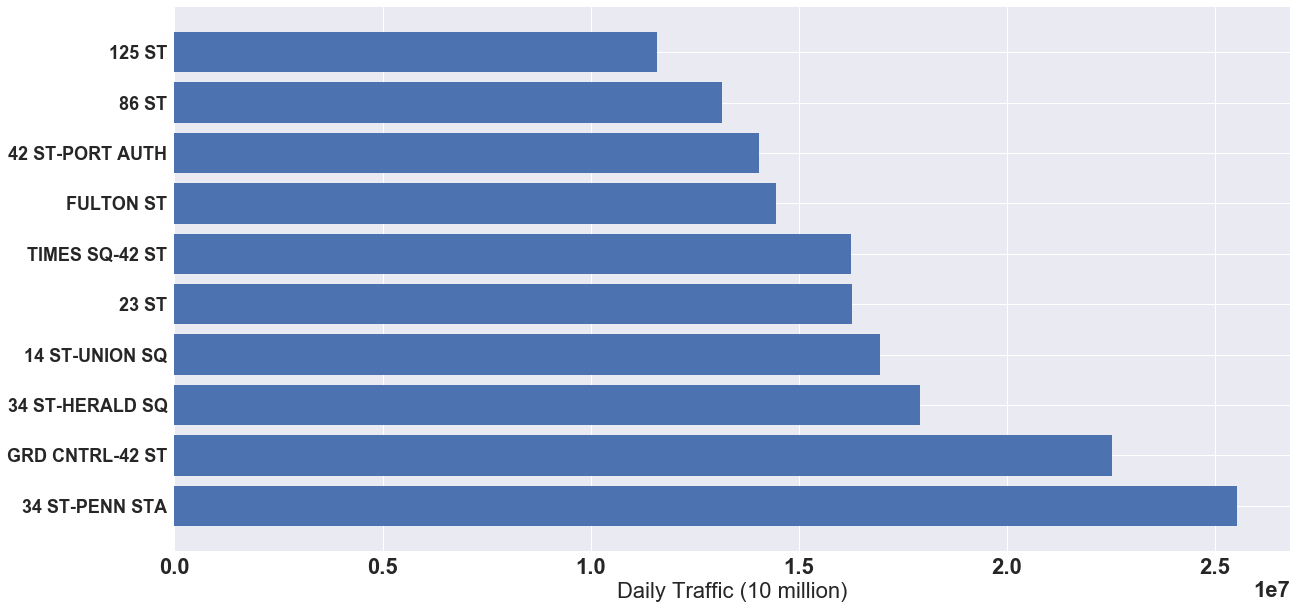

In [459]:
# Ploting the top 10
plotsta = mostpopular[0:10]
plot = plt.barh(plotsta.STATION, plotsta.DIFF)
plot = plt.style.use('seaborn')
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=18)
plt.xlabel('Daily Traffic (10 million)', fontsize=22)

In [440]:
# Merge the most popular station with zipcode
Zipcode = pd.read_csv('zipcode.csv')
Zipcode.columns = ['STATION', 'ZIPCODE']
merged = pd.merge(mostpopular, Zipcode, how='left', on='STATION')

In [60]:
# Merge the most popular station with Station_Latitude & Station_Longitude
df2 = pd.read_csv('StationEntrances.csv')
LatLong = df2[['Station_Name', 'Station_Latitude', 'Station_Longitude']]
LatLong = LatLong.drop_duplicates(subset=['Station_Name']).reset_index(drop=True)
LatLong['Station_Name'] = LatLong['Station_Name'].apply(lambda x: x.upper())
LatLong['STATION'] = [re.sub(r"(\d)(ST)", r"1", Name) for Name in LatLong.Station_Name]
LatLong['STATION'] = [re.sub(r"(ND|RD|TH)", r"", Name) for Name in LatLong.Station_Name]
LatLong.drop(['Station_Name'], axis=1, inplace=True)
merged = pd.merge(mostpopular, LatLong, how='left', on='STATION')